In [5]:
from collections import defaultdict
import math as mt

In [6]:
def markov(seqs, m):

    bases = ['A', 'C', 'G', 'T']
    
    transition_counts = defaultdict(lambda: defaultdict(int))
    context_counts = defaultdict(int)

    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - m):
            context = seq[i:i+m]
            next_base = seq[i+m]

            if next_base in bases:
                transition_counts[context][next_base] += 1
                context_counts[context] += 1

    transition_probs = {}

    for context in context_counts:
        transition_probs[context] = {}
        total = context_counts[context]

        for base in bases:
            count = transition_counts[context][base]
            transition_probs[context][base] = (count + 1) / (total + 4)

    return transition_probs


In [ ]:
#print transition matrix

probs = markov(seqs, m)

bases = ['A', 'C', 'G', 'T']

print("Context\tA\tC\tG\tT")

for context in sorted(probs.keys()):
    row = [f"{probs[context][base]:.3f}" for base in bases]
    print(f"{context}\t" + "\t".join(row))


In [7]:
def log_score(seq, m, model):

    log_prob = 0.0
    seq = seq.upper()

    for i in range(len(seq) - m):
        context = seq[i:i+m]
        next_base = seq[i+m]

        if context in model:
            prob = model[context][next_base]
        else:
            prob = 1/4

        log_prob += mt.log(prob)

    return log_prob


In [8]:
import pandas as pd

data = pd.read_csv('all_chr_200bp_bins.tsv', sep = '\t')

data['region'] = (data['chr'] + ':' + data['start'].astype(str) + '-' + data['end'].astype(str))

# Build dictionary: region -> B/U
labels = dict(zip(data['region'], data['CTCF']))


C:\Users\sindh\AppData\Local\Temp\ipykernel_844\2795352313.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('all_chr_200bp_bins.tsv', sep = '\t')


In [9]:
#parsing data

from Bio import SeqIO

input_chrom = 'chr4'

B_seqs = []
U_seqs = []

for record in SeqIO.parse('output3.fa', 'fasta'):
    
    region = record.id            
    chrom = region.split(":")[0]  
    
    if chrom != input_chrom:
        continue
    
    label = labels.get(region)
    
    if label == "B":
        B_seqs.append(str(record.seq))
    elif label == "U":
        U_seqs.append(str(record.seq))


In [10]:
#creating splits

import random

def kfold_split(data, k):
    data = data.copy()
    random.shuffle(data)
    fold_size = len(data) // k
    
    folds = []
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i != k - 1 else len(data)
        folds.append(data[start:end])
    
    return folds

k = 5

B_folds = kfold_split(B_seqs, k)
U_folds = kfold_split(U_seqs, k)

In [24]:
m = 3

y_true = []
y_scores = []

for i in range(k):

    # Test fold
    B_test = B_folds[i]
    U_test = U_folds[i]

    # Training folds (everything except i)
    B_train = [seq for j in range(k) if j != i for seq in B_folds[j]]
    U_train = [seq for j in range(k) if j != i for seq in U_folds[j]]

    # Train models
    model_B = markov(B_train, m)
    model_U = markov(U_train, m)

    for seq in B_test:
        llr = log_score(seq, m, model_B) - log_score(seq, m, model_U)
        y_true.append(1)
        y_scores.append(llr)

    for seq in U_test:
        llr = log_score(seq, m, model_B) - log_score(seq, m, model_U)
        y_true.append(0)
        y_scores.append(llr)



In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

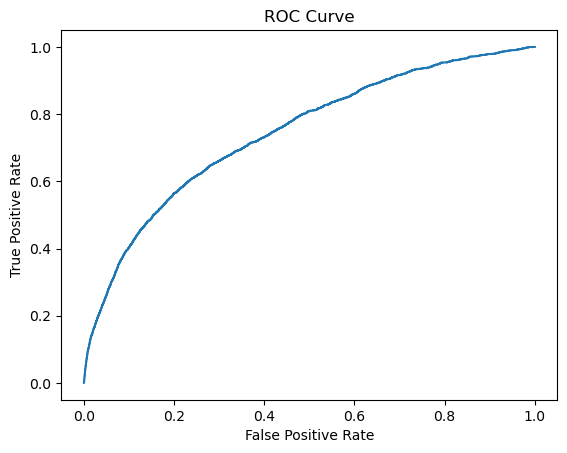

AUC: 0.7443878909466004


In [26]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("AUC:", roc_auc)

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

ap = average_precision_score(y_true, y_scores)

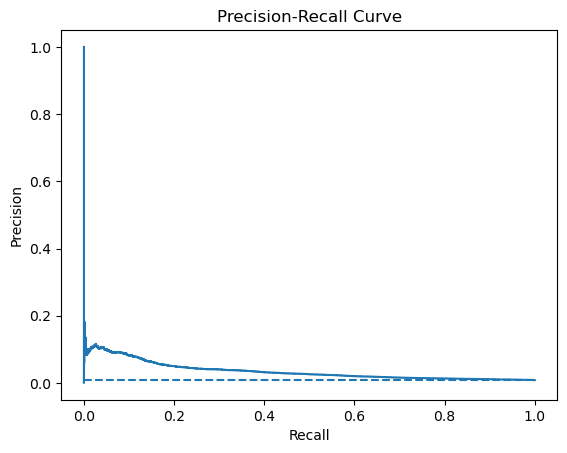

Average Precision: 0.0348670899139371


In [27]:
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
baseline = sum(y_true) / len(y_true)
plt.hlines(baseline, 0, 1, linestyles="--")
plt.show()

print("Average Precision:", ap)